In [16]:
# ライブラリのインポート
import matplotlib.pyplot as plt

import argparse

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import tensorflow as tf

# データセットの読み込みと前処理

In [17]:
# Fashion-MNISTデータセットの読み込み
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# (28,28)の画像データを(784)のベクトルに変換して正規化を行う 
# (60000, 28, 28)の訓練データを(60000, 784)の2階テンソルに変換
x_train = x_train.reshape(-1, 784)

# 訓練データをfloat32(浮動小数点数)型に、255で割ってスケール変換する
x_train = x_train.astype('float32') / 255

# (10000, 28, 28)のテストデータを(10000, 784)の2階テンソルに変換
x_test = x_test.reshape(-1, 784)

# テストデータをfloat32(浮動小数点数)型に、255で割ってスケール変換する
x_test = x_test.astype('float32') / 255

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(60000, 784)
(60000,)
(10000, 784)
(10000,)


In [18]:
# 正解ラベルのOne-Hotエンコーディング

# クラスの数
class_num = 10

# 訓練データの正解ラベルをOne-Hot表現に変換
y_train = tf.keras.utils.to_categorical(y_train, class_num)

# テストデータの正解ラベルをOne-Hot表現に変換
y_test = tf.keras.utils.to_categorical(y_test, class_num)

print('-----------------')
print('y_train[0]   :', y_train[0])
print('y_train[0]   :', y_test[0])
print('y_train.shape:', y_train.shape)
print('y_test.shape:',y_test.shape)

-----------------
y_train[0]   : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
y_train[0]   : [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
y_train.shape: (60000, 10)
y_test.shape: (10000, 10)


In [19]:
# ハイパーパラメータの設定
parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=500)
parser.add_argument('--batch_size', type=int, default=64)
parser.add_argument('--patience', type=int, default=20) # earlystoppingの監視対象回数
parser.add_argument('--lr', type=int, default=0.001)
opt = parser.parse_args(args=[])
print(opt)

Namespace(batch_size=64, epochs=500, lr=0.001, patience=20)


# モデルの定義


In [20]:
class MLP(tf.keras.Model):
    '''多層パーセプトロン
    
    Attributes:
      l1(Dense): 隠れ層
      l2(Dense): 出力層
    '''
    def __init__(self, hidden_dim, output_dim):
        '''
        Parameters:
          hidden_dim(int): 隠れ層のユニット数(次元)
          output_dim(int): 出力層のユニット数(次元)
        '''
        super().__init__()
        # 隠れ層：活性化関数はReLU
        self.fc1 = tf.keras.layers.Dense(hidden_dim, activation='relu')
        # 出力層：活性化関数はソフトマックス
        self.fc2 = tf.keras.layers.Dense(output_dim, activation='softmax')

    @tf.function
    def call(self, x, training=None):
        '''MLPのインスタンスからコールバックされる関数
        
        Parameters: x(ndarray(float32)):訓練データ、または検証データ
        Returns(float32): MLPの出力として要素数3の1階テンソル        
        '''
        x = self.fc1(x) # 第1層の出力
        x = self.fc2(x) # 出力層の出力
        return x

# 損失関数とオプティマイザーの生成

In [21]:
# マルチクラス分類のクロスエントロピー誤差を求めるオブジェクト
loss_fn = tf.keras.losses.CategoricalCrossentropy()

# 勾配降下アルゴリズムを使用するオプティマイザーを生成
optimizer = tf.keras.optimizers.SGD(learning_rate=opt.lr)

# 勾配降下アルゴリズムによるパラメーターの更新処理を行うtrain_step()関数

In [22]:
# 損失を記録するオブジェクトを生成
train_loss = tf.keras.metrics.Mean()

# カテゴリカルデータの精度を記録するオブジェクトを生成
train_accuracy = tf.keras.metrics.CategoricalAccuracy()

In [23]:
@tf.function
def train_step(x, t):
    '''学習を1回行う
    
    Parameters: x(ndarray(float32)):訓練データ
                t(ndarray(float32)):正解ラベル
                
    Returns:
      ステップごとのクロスエントロピー誤差
    '''
    # 自動微分による勾配計算を記録するブロック
    with tf.GradientTape() as tape:
        # 訓練モードをTrueに指定し、
        # モデルに入力して順伝搬の出力値を取得
        outputs = model(x, training=True)
        # 出力値と正解ラベルの誤差
        tmp_loss = loss_fn(t, outputs)
        
    # tapeに記録された操作を使用して誤差の勾配を計算        
    grads = tape.gradient(
        # 現在のステップの誤差
        tmp_loss,
        # バイアス、重みのリストを取得
        model.trainable_variables)
    # 勾配降下法の更新式を適用してバイアス、重みを更新
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # 損失をMeanオブジェクトに記録
    train_loss(tmp_loss)
    # 精度をCategoricalAccuracyオブジェクトに記録
    train_accuracy(t, outputs)

# 検証を行うvalid_step()関数

In [24]:
# 損失を記録するオブジェクトを生成
val_loss = tf.keras.metrics.Mean()
# カテゴリカルデータの精度を記録するオブジェクトを生成
val_accuracy = tf.keras.metrics.CategoricalAccuracy()

@tf.function
def valid_step(val_x, val_y):
    # 訓練モードをTrueに指定し、
    # モデルに入力して順伝搬の出力値を取得
    pred = model(val_x, training = False)
    # 出力値と正解ラベルの誤差
    tmp_loss = loss_fn(val_y, pred)
    # 損失をMeanオブジェクトに記録
    val_loss(tmp_loss)
    # 精度をCategoricalAccuracyオブジェクトに記録
    val_accuracy(val_y, pred)

# 学習の進捗を監視し早期終了判定を行うクラス

In [25]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=0):
        '''
        Parameters:
            patience(int): 監視するエポック数(デフォルトは10)
            verbose(int): 早期終了の出力フラグ
                          出力(1),出力しない(0)        
        '''
        # インスタンス変数の初期化
        # 監視中のエポック数のカウンターを初期化
        self.epoch = 0
        # 比較対象の損失を無限大'inf'で初期化
        self.pre_loss = float('inf')
        # 監視対象のエポック数をパラメーターで初期化
        self.patience = patience
        # 早期終了メッセージの出力フラグをパラメーターで初期化
        self.verbose = verbose
        
    def __call__(self, current_loss):
        '''
        Parameters:
            current_loss(float): 1エポック終了後の検証データの損失
        Return:
            True:監視回数の上限までに前エポックの損失を超えた場合
            False:監視回数の上限までに前エポックの損失を超えない場合
        '''
        # 前エポックの損失より大きくなった場合
        if self.pre_loss < current_loss:
            # カウンターを1増やす
            self.epoch += 1
            # 監視回数の上限に達した場合
            if self.epoch > self.patience:
                # 早期終了のフラグが1の場合
                if self.verbose:
                    # メッセージを出力
                    print('early stopping')
                # 学習を終了するTrueを返す
                return True
        # 前エポックの損失以下の場合
        else:
            # カウンターを0に戻す
            self.epoch = 0
            # 損失の値を更新する
            self.pre_loss = current_loss
        
        # 監視回数の上限までに前エポックの損失を超えなければ
        # Falseを返して学習を続行する
        # 前エポックの損失を上回るが監視回数の範囲内であれば
        # Falseを返す必要があるので、return文の位置はここであることに注意
        return False

# 訓練データと検証データの用意

In [26]:
# 訓練データと検証データに8：2の割合で分割  \は行継続文字
tr_x, val_x, tr_y, val_y = \
    train_test_split(x_train, y_train, test_size=0.2)
print(tr_x.shape)
print(val_x.shape)
print(tr_y.shape)
print(val_y.shape)

(48000, 784)
(12000, 784)
(48000, 10)
(12000, 10)


# モデルを生成して学習する

In [27]:
# 訓練データのステップ数
tr_steps = tr_x.shape[0] // opt.batch_size
# 検証データのステップ数
val_steps = val_x.shape[0] // opt.batch_size

# 隠れ層256ユニット、出力層10ユニットのモデルを生成
model = MLP(256, 10)
# 損失と精度の履歴を保存するためのdictオブジェクト
history = {'loss':[],'accuracy':[], 'val_loss':[], 'val_accuracy':[]}

# 早期終了の判定を行うオブジェクトを生成
ers = EarlyStopping(patience=opt.patience, # 監視対象回数
                    verbose=1)  # 早期終了時にメッセージを出力

# 学習を行う
for epoch in range(opt.epochs):
    # 学習するたびに、記録された値をリセット
    train_loss.reset_states()     # 訓練時における損失の累計
    train_accuracy.reset_states() # 訓練時における精度の累計
    val_loss.reset_states()       # 検証時における損失の累計
    val_accuracy.reset_states()   # 検証時における精度の累計

    # 訓練データと正解ラベルをシャッフル
    x_, y_ = shuffle(tr_x, tr_y, )
    
    # 1ステップにおける訓練用ミニバッチを使用した学習
    for step in range(tr_steps):
        start = step * opt.batch_size # ミニバッチの先頭インデックス
        end = start + opt.batch_size  # ミニバッチの末尾のインデックス
        # ミニバッチでバイアス、重みを更新して誤差を取得
        train_step(x_[start:end], y_[start:end])

    # 1ステップにおける検証用ミニバッチを使用した評価
    for step in range(val_steps):
        start = step * opt.batch_size # ミニバッチの先頭インデックス
        end = start + opt.batch_size  # ミニバッチの末尾のインデックス
        # ミニバッチでバイアス、重みを更新して誤差を取得
        valid_step(val_x[start:end], val_y[start:end])

    avg_train_loss = train_loss.result()    # 訓練時の平均損失値を取得
    avg_train_acc = train_accuracy.result() # 訓練時の平均正解率を取得
    avg_val_loss = val_loss.result()     # 検証時の平均損失値を取得
    avg_val_acc = val_accuracy.result()  # 検証時の平均正解率を取得

    # 損失の履歴を保存する
    history['loss'].append(avg_train_loss)
    history['val_loss'].append(avg_val_loss)
    # 精度の履歴を保存する
    history['accuracy'].append(avg_train_acc)
    history['val_accuracy'].append(avg_val_acc)

    # 1エポックごとに結果を出力
    if (epoch + 1) % 1 == 0:
        print(
            'epoch({}) train_loss: {:.4} train_acc: {:.4} val_loss: {:.4} val_acc: {:.4}'.format(
                epoch+1,
                avg_train_loss,     # 現在の損失を出力
                avg_train_acc,      # 現在の精度を出力
                avg_val_loss, # 現在の損失を出力
                avg_val_acc   # 現在の精度を出力
    ))
    
    # 検証データの損失をEarlyStoppingオブジェクトに渡して早期終了を判定
    if ers(val_loss.result()):
        # 監視対象のエポックで損失が改善されなければ学習を終了
        break

# モデルの概要を出力
model.summary()

epoch(1) train_loss: 1.727 train_acc: 0.5097 val_loss: 1.354 val_acc: 0.6367
epoch(2) train_loss: 1.196 train_acc: 0.6583 val_loss: 1.063 val_acc: 0.6731
epoch(3) train_loss: 0.9945 train_acc: 0.6904 val_loss: 0.9224 val_acc: 0.7033
epoch(4) train_loss: 0.8874 train_acc: 0.7171 val_loss: 0.84 val_acc: 0.7303
epoch(5) train_loss: 0.8205 train_acc: 0.7365 val_loss: 0.7869 val_acc: 0.7445
epoch(6) train_loss: 0.7736 train_acc: 0.7505 val_loss: 0.7451 val_acc: 0.7564
epoch(7) train_loss: 0.7381 train_acc: 0.7615 val_loss: 0.7143 val_acc: 0.7681
epoch(8) train_loss: 0.7096 train_acc: 0.7714 val_loss: 0.688 val_acc: 0.7769
epoch(9) train_loss: 0.6861 train_acc: 0.7778 val_loss: 0.6668 val_acc: 0.7841
epoch(10) train_loss: 0.6665 train_acc: 0.785 val_loss: 0.6483 val_acc: 0.7884
epoch(11) train_loss: 0.6495 train_acc: 0.7891 val_loss: 0.6329 val_acc: 0.7923
epoch(12) train_loss: 0.6349 train_acc: 0.7934 val_loss: 0.6187 val_acc: 0.799
epoch(13) train_loss: 0.622 train_acc: 0.7983 val_loss: 0.

# 損失の推移をグラフにする

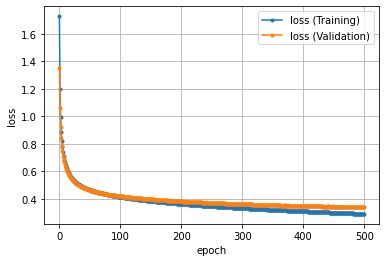

In [28]:
plt.plot(history['loss'], marker='.', label='loss (Training)') # 訓練データの損失
plt.plot(history['val_loss'], marker='.', label='loss (Validation)') # 検証データの損失
plt.legend(loc='best') # 凡例最適な位置にを出力
plt.grid()             # グリッドを表示
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

# 精度の推移をグラフにする

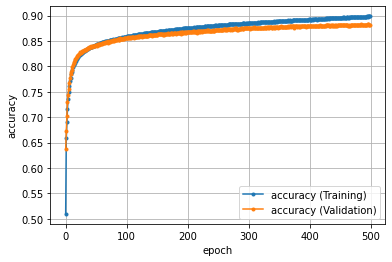

In [29]:
plt.plot(history['accuracy'], marker='.', label='accuracy (Training)') # 訓練データの精度
plt.plot(history['val_accuracy'], marker='.', label='accuracy (Validation)') # 検証データの精度
plt.legend(loc='best') # 凡例最適な位置にを出力
plt.grid()             # グリッドを表示
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# テストデータによるモデルの評価

In [30]:
# テストデータの予測値を取得
test_preds = model(x_test)

# カテゴリカルデータの精度を取得するオブジェクト
categor_acc = tf.keras.metrics.CategoricalAccuracy()

# 精度を測定するデータを設定
categor_acc.update_state(y_test, test_preds)

# テストデータの精度を取得
test_acc = categor_acc.result().numpy()

# テストデータの損失を取得
test_loss = loss_fn(y_test, test_preds)

print('test_loss: {:.4f}, test_acc: {:.4f}'.format(
    test_loss,
    test_acc
))

test_loss: 0.3658, test_acc: 0.8726
